# Compute the annual count of days when precipitation exceeds a given threshold

### Example: Annual count of days when PRCP ≥ 10mm

Let RR<sub>ij</sub> be the daily precipitation amount on day i in period j. Count the number of days where 

\begin{equation*} 
RRij ≥ 10mm
\end{equation*}

The notebook will exploit:
- an **intake** catalog to search and discover CMIP6 data
- **xarray** to compute the climate index
- **Cartopy** and **Matplotlib** to plot the results.

Make sure to select **Python [conda env:climate]** as Notebook Kernel.

Import the main Python modules

In [1]:
import os, intake
import multiprocessing
import dask
import xarray as xr
import numpy as np
import pandas as pd
import ipywidgets as widgets

**Search and discover datasets by using *intake-esm***

Climate datasets are stored on the OpenStack Swift instance deployed at DKRZ premises.
We can use the **intake-esm** (https://github.com/intake/intake-esm) data cataloging utility to search, discover, access and load data.

An ESM (Earth System Model) collection definition file is used by intake-esm to establish a link to a database (CSV file) that contains data assets locations and associated metadata (i.e., which experiment, model, ...).

The ESM collection file is located at **https://swift.dkrz.de/v1/dkrz_0b2a0dcc-1430-4a8a-9f25-a6cb8924d92b/CMCC_CMIP/catalog.json**.

In [2]:
col = intake.open_esm_datastore("https://swift.dkrz.de/v1/dkrz_0b2a0dcc-1430-4a8a-9f25-a6cb8924d92b/CMCC_CMIP/catalog.json")
col

The output shows that cmip6 catalog contains 14 datasets. In addition, the output provides some aggregated information over the metadata fields, which represents the core components to describe cmip6 datasets according to the data reference syntax.
For example, in the catalog the available datasets refer to 3 different models from only 1 institution, 3 experiments, 4 variables.

The in-memory representation for the catalog is a Pandas DataFrame. We can inspect it with **col.df**.

In [3]:
col.df.head()

prefix  \
0  CMIP6.CMIP.CMCC.CMCC-CM2-HR4.historical.r1i1p1...   
1  CMIP6.CMIP.CMCC.CMCC-CM2-HR4.historical.r1i1p1...   
2  CMIP6.CMIP.CMCC.CMCC-CM2-SR5.historical.r1i1p1...   
3  CMIP6.CMIP.CMCC.CMCC-CM2-SR5.historical.r1i1p1...   
4  CMIP6.CMIP.CMCC.CMCC-ESM2.historical.r1i1p1f1....   

                                                 url mip_era activity_id  \
0  https://swift.dkrz.de/v1/dkrz_0b2a0dcc-1430-4a...   CMIP6        CMIP   
1  https://swift.dkrz.de/v1/dkrz_0b2a0dcc-1430-4a...   CMIP6        CMIP   
2  https://swift.dkrz.de/v1/dkrz_0b2a0dcc-1430-4a...   CMIP6        CMIP   
3  https://swift.dkrz.de/v1/dkrz_0b2a0dcc-1430-4a...   CMIP6        CMIP   
4  https://swift.dkrz.de/v1/dkrz_0b2a0dcc-1430-4a...   CMIP6        CMIP   

  institution_id     source_id experiment_id member_id table_id variable_id  \
0           CMCC  CMCC-CM2-HR4    historical  r1i1p1f1      day          pr   
1           CMCC  CMCC-CM2-HR4    historical  r1i1p1f1      day         tas   
2           CMCC  CMCC-CM2-SR5    historical  r1i1p1f1      day          pr   
3           CMCC  CMCC-CM2-SR5    historical  r1i1p1f1      day         tas   
4           CMCC     CMCC-ESM2    historical  r1i1p1f1      day      tasmax   

  grid_label    version  
0         gn  v20200904  
1         gn  v20200904  
2         gn  v20200616  
3         gn  v20200616  
4         gn  v20210114

Get unique values for **models** and **experiments** in the catalog.

In [4]:
uniques = col.unique(columns=["source_id","experiment_id"])
uniques

{'source_id': {'count': 3,
  'values': ['CMCC-CM2-SR5', 'CMCC-ESM2', 'CMCC-CM2-HR4']},
 'experiment_id': {'count': 3, 'values': ['ssp245', 'historical', 'ssp585']}}

Select one of the models and experiments available

In [5]:
sources = widgets.Dropdown(
    options=uniques['source_id']['values'],
    value=uniques['source_id']['values'][0],
    description='Source:',
    disabled=False,
)
display(sources)

experiments = widgets.Dropdown(
    options=uniques['experiment_id']['values'],
    value=uniques['experiment_id']['values'][0],
    description='Experiment:',
    disabled=False,
)
display(experiments)

Dropdown(description='Source:', options=('CMCC-CM2-SR5', 'CMCC-ESM2', 'CMCC-CM2-HR4'), value='CMCC-CM2-SR5')

Dropdown(description='Experiment:', options=('ssp245', 'historical', 'ssp585'), value='ssp245')

In [6]:
print(sources.value)
print(experiments.value)

CMCC-CM2-SR5
ssp245


Execute a query against the catalog to retrieve entries satisfyng the search criteria

In [7]:
query = dict( experiment_id=experiments.value,
             source_id=sources.value, 
             variable_id="pr",
)
cat = col.search(**query)
cat.df

prefix  \
0  CMIP6.ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp245.r1i...   
1  CMIP6.ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp245.r1i...   

                                                 url mip_era  activity_id  \
0  https://swift.dkrz.de/v1/dkrz_0b2a0dcc-1430-4a...   CMIP6  ScenarioMIP   
1  https://swift.dkrz.de/v1/dkrz_0b2a0dcc-1430-4a...   CMIP6  ScenarioMIP   

  institution_id     source_id experiment_id member_id table_id variable_id  \
0           CMCC  CMCC-CM2-SR5        ssp245  r1i1p1f1      day          pr   
1           CMCC  CMCC-CM2-SR5        ssp245  r1i1p1f1      day          pr   

  grid_label    version  
0         gn  v20200617  
1         gn  v20200622

Load data assets into xarray datasets

In [8]:
xrdsetdict = cat.to_dataset_dict()
xrdsetdict


--> The keys in the returned dictionary of datasets are constructed as follows:
	'prefix.url.mip_era.activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.version'


{'CMIP6.ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp245.r1i1p1f1.day.pr.gn.v20200622.https://swift.dkrz.de/v1/dkrz_0b2a0dcc-1430-4a8a-9f25-a6cb8924d92b/CMCC_CMIP/CMIP6.ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp245.r1i1p1f1.day.pr.gn.v20200622.CMIP6.ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp245.r1i1p1f1.day.pr.gn.v20200622': <xarray.Dataset>
 Dimensions:    (lat: 192, bnds: 2, lon: 288, time: 31390)
 Coordinates:
   * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
   * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
   * time       (time) object 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
 Dimensions without coordinates: bnds
 Data variables:
     lat_bnds   (lat, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
     lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
     pr         (time, lat, lon) float32 dask.array<chunksize=(469, 192, 288), meta=np.ndarray>
     time_bnds  (time, bnds) object dask.array<chunksize=(1569

Get the first dataset

In [9]:
dspr = xrdsetdict[[key for key in xrdsetdict.keys()] [0]]
dspr

<xarray.Dataset>
Dimensions:    (lat: 192, bnds: 2, lon: 288, time: 31390)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(469, 192, 288), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(15695, 2), meta=np.ndarray>
Attributes: (12/49)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             ScenarioMIP
    branch_method:           standard
    branch_time_in_child:    60225.0
    branch_time_in_parent:   60225.0
    cmor_version:            3.5.0
    ...                      ...
    title:                   CMCC-CM2-SR5 output prepared for CMIP6
    tracking_id:             b5adf3f1-3d07-439b-9b47-e953a3f37d13
    variable_id:             pr
    variant_label:           r1i1p1f1
    intake_esm_varname:      None
    intake_esm_dataset_key:  CMIP6.ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp245.r1i1p...

In [10]:
print("Start year: "+str(np.min(dspr.time.dt.year.values)))
print("End year: "+str(np.max(dspr.time.dt.year.values)))

Start year: 2015
End year: 2100


Select the time ranges of interest among those available for the filtered data and run the next cell to check the selection.

In [11]:
start_time = widgets.Dropdown(
    options=np.unique(dspr.time.dt.year.values),
    value=[np.unique(dspr.time.dt.year.values)[0]],
    description='Time range:',
    disabled=False,
)
display(start_time)

end_time = widgets.Dropdown(
    options=np.unique(dspr.time.dt.year.values),
    value=[np.unique(dspr.time.dt.year.values)[0]],
    description='Time range:',
    disabled=False,
)
display(end_time)

Dropdown(description='Time range:', options=(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025,…

Dropdown(description='Time range:', options=(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025,…

In [13]:
print(start_time.value)
print(end_time.value)
tashist = dspr.sel(time=dspr.time.dt.year.isin(range(start_time.value, end_time.value+1)))
tashist

2015
2050


<xarray.Dataset>
Dimensions:    (lat: 192, bnds: 2, lon: 288, time: 13140)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 2015-01-01 12:00:00 ... 2050-12-31 12:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(469, 192, 288), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(13140, 2), meta=np.ndarray>
Attributes: (12/49)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             ScenarioMIP
    branch_method:           standard
    branch_time_in_child:    60225.0
    branch_time_in_parent:   60225.0
    cmor_version:            3.5.0
    ...                      ...
    title:                   CMCC-CM2-SR5 output prepared for CMIP6
    tracking_id:             b5adf3f1-3d07-439b-9b47-e953a3f37d13
    variable_id:             pr
    variant_label:           r1i1p1f1
    intake_esm_varname:      None
    intake_esm_dataset_key:  CMIP6.ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp245.r1i1p...

Count the number of days (on yearly basis) exceeding the given threshold

**NOTE:** The precipitation is expressed in *kg m-2 s-1*, so a scale factor is needed to convert the unit in *mm/day*.

In [14]:
%%time
def annual_rnmm(tashist, mm_threshold):
    
    def _count_rnmm(x, axis):
            factor=86400  # 1 kg/m2/s = 86400 mm/day
            return np.sum(x >= (mm_threshold/factor), axis=axis)
        
    total = tashist['pr'].groupby('time.year').reduce(_count_rnmm)
    return total

mm_threshold=10.0
rnmm = annual_rnmm(tashist, mm_threshold)
rnmm

CPU times: user 174 ms, sys: 7.41 ms, total: 181 ms
Wall time: 179 ms


<xarray.DataArray 'pr' (year: 36, lat: 192, lon: 288)>
dask.array<stack, shape=(36, 192, 288), dtype=int64, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2046 2047 2048 2049 2050

Get coordinate arrays

In [15]:
rnmm.coords

Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2046 2047 2048 2049 2050

Select one year (whole spatial domain)

In [16]:
year=2050
rnmm_one_year=rnmm.sel(year=year)
rnmm_one_year

<xarray.DataArray 'pr' (lat: 192, lon: 288)>
dask.array<getitem, shape=(192, 288), dtype=int64, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    year     int64 2050

Plot the results on a map

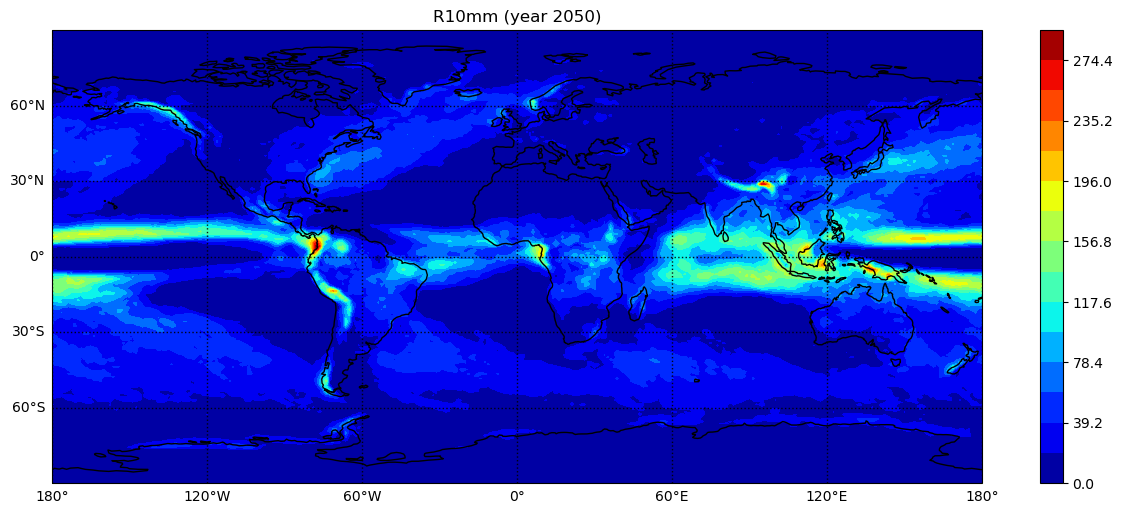

In [17]:
%matplotlib inline
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.util import add_cyclic_point
import numpy as np
import warnings
warnings.filterwarnings("ignore")

lat = rnmm_one_year['lat'].values
lon = rnmm_one_year['lon'].values
var = rnmm_one_year.values

fig = plt.figure(figsize=(15, 6), dpi=100)

#Add Geo axes to the figure with the specified projection (PlateCarree)
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)

#Draw coastline and gridlines
ax.coastlines()
gl = ax.gridlines(crs=projection, draw_labels=True, linewidth=1, color='black', alpha=0.9, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False

var = np.reshape(var, (len(lat), len(lon)))

#Wraparound points in longitude
var_cyclic, lon_cyclic = add_cyclic_point(var, coord=lon)
x, y = np.meshgrid(lon_cyclic,lat)

#Define color levels for color bar
levStep = (np.max(var)-np.min(var))/15
clevs = np.arange(np.min(var),np.max(var)+levStep,levStep)

#Set filled contour plot
cnplot = ax.contourf(x, y, var_cyclic, clevs, transform=projection,cmap=plt.cm.jet)
plt.colorbar(cnplot,ax=ax)

ax.set_aspect('auto', adjustable=None)
plt.title('R10mm (year '+str(year)+')')
plt.show()

Select one spatial point (whole time series)

In [18]:
rnmm_one_point=rnmm.sel(lat=54, lon=7,method='nearest')
rnmm_one_point

<xarray.DataArray 'pr' (year: 36)>
dask.array<getitem, shape=(36,), dtype=int64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 54.19
    lon      float64 7.5
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2046 2047 2048 2049 2050

Plot results on a graph

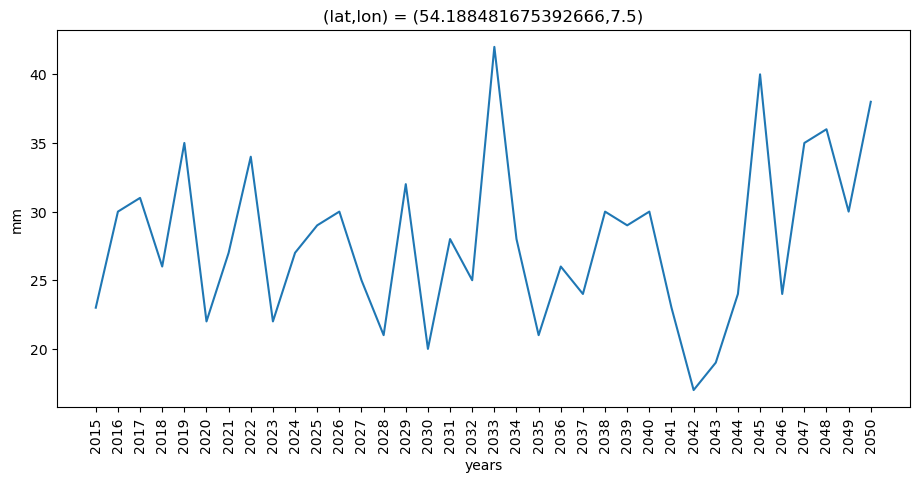

In [19]:
%matplotlib inline

import matplotlib.pyplot as plt
y = rnmm_one_point.values
x = rnmm_one_point.year.values
plt.figure(figsize=(11, 5), dpi=100)
#plt.grid(zorder=0)
plt.plot(x, y)

plt.ylabel("mm")
plt.xlabel("years")
plt.title("(lat,lon) = ("+str(rnmm_one_point.lat.values)+',' +str(rnmm_one_point.lon.values)+")")
plt.xticks([p for p in x[::1]], x[::1], rotation='vertical')
plt.show()